# ARIMA MODEL 


##### Step 1. Import modules and load dataset

In [1]:
#Import required Libraries
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('NKG Historical Data.csv',delimiter=",", thousands=',')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,24400.0,24500.0,24700.0,24300.0,4.89M,0.21%
1,05/30/2024,24350.0,24400.0,24650.0,24150.0,6.99M,-1.62%
2,05/29/2024,24750.0,25250.0,25600.0,24750.0,8.00M,-1.20%
3,05/28/2024,25050.0,25250.0,25250.0,24850.0,4.43M,0.60%
4,05/27/2024,24900.0,24600.0,24900.0,24600.0,4.31M,0.40%
...,...,...,...,...,...,...,...
1308,03/07/2019,4934.5,5217.0,5217.0,4934.5,1.29M,-3.59%
1309,03/06/2019,5118.5,5223.6,5256.5,5118.5,697.98K,-2.01%
1310,03/05/2019,5223.6,5328.7,5387.9,5223.6,2.48M,0.00%
1311,03/04/2019,5223.6,5256.5,5289.3,5125.1,1.92M,3.25%


In [3]:
# Determine the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1313 non-null   object 
 1   Price     1313 non-null   float64
 2   Open      1313 non-null   float64
 3   High      1313 non-null   float64
 4   Low       1313 non-null   float64
 5   Vol.      1313 non-null   object 
 6   Change %  1313 non-null   object 
dtypes: float64(4), object(3)
memory usage: 71.9+ KB


In [4]:
# Convert data
df['Date'] = pd.to_datetime(df['Date'])

##### Step 2. Selecting attribute 

In [5]:
df = df[['Price']]
df = df.dropna() 
df = df.reset_index(drop=True) 
df

,Price
0,24400.0
1,24350.0
2,24750.0
3,25050.0
4,24900.0
...,...
1308,4934.5
1309,5118.5
1310,5223.6
1311,5223.6


##### Step 3. Split the dataset into train, test, validate

In [6]:
# Calculate the number of samples for each set
train_size = int(0.80 * len(df))
test_size = int(0.20 * len(df))

# Split data into sets
train_data = df[:train_size]
test_data = df[train_size:]

# Check the size of each set
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1050
Test data size: 263


##### Step 4. Process of training the model

In [7]:
#ADF test
r = adfuller(train_data, autolag='AIC', regression='ct')
print('ADF Statistic: {}'.format(r[0]))
print('p-value: {}'.format(r[1]))
print('Critical Values:')
for key, value in r[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.596303915934785
p-value: 0.793876353754835
Critical Values:
	1%: -3.9675521264097227
	5%: -3.4147445273860986
	10%: -3.1295542716349165


In [8]:
print('ADF Statistic for 1st Order Differencing')
result = adfuller(train_data.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for 1st Order Differencing
ADF Statistic: -7.054704
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


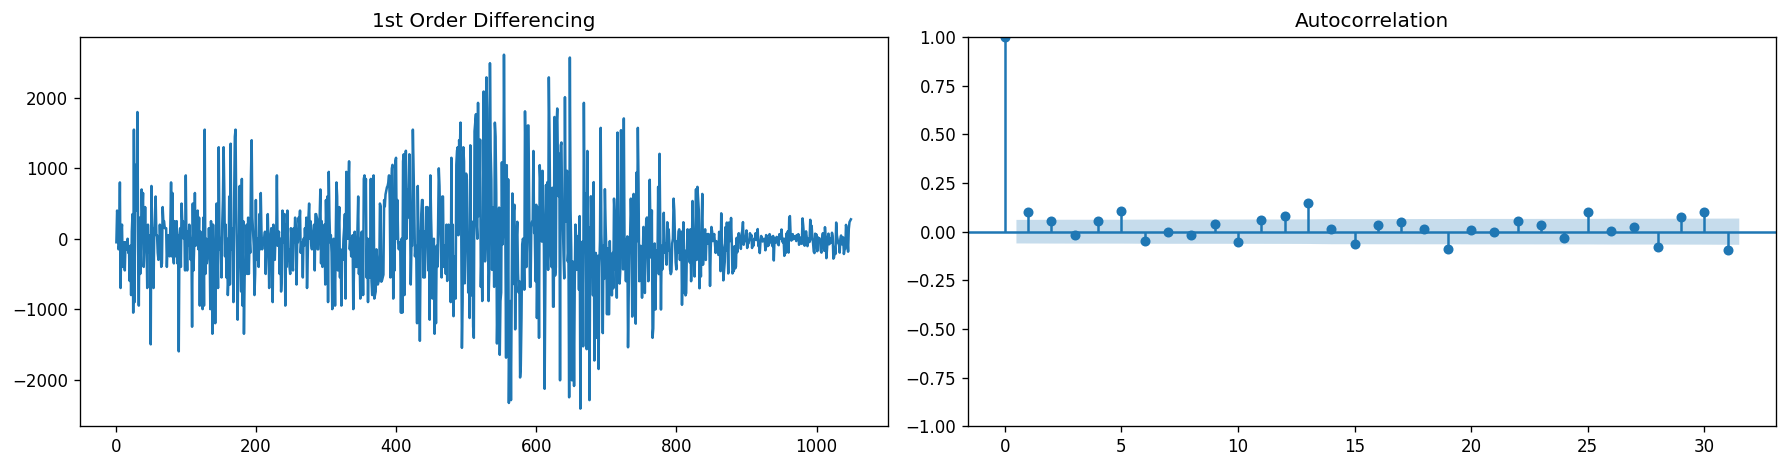

In [9]:
plt.rcParams.update({'figure.figsize': (15, 4), 'figure.dpi': 120})

# 1st Differencing
fig, ax = plt.subplots(1, 2)  # Create a figure with 1 row and 2 columns
ax[0].plot(train_data.diff()); ax[0].set_title('1st Order Differencing')
plot_acf(train_data.diff().dropna(), ax=ax[1])  # Use ax[1] for ACF plot

plt.tight_layout() 
plt.show()

In [10]:
!pip install pmdarima

In [11]:
# Process of Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train model
from pmdarima.arima import auto_arima
model = auto_arima(y_train, d=1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16559.648, Time=5.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16589.314, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16581.852, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16582.744, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16588.241, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16581.662, Time=3.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16582.785, Time=1.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16576.060, Time=6.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16575.297, Time=7.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16581.844, Time=1.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16583.800, Time=2.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16584.561, Time=2.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=16573.320, Time=6.55 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=16572.655, Time=7.11 sec

Best model:  ARIMA

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [12]:
# Process of Testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

##### Step 5. Evaluate the accuracy of test sets

In [13]:
# RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('RMSE:', test_rmse)

RMSE: 2008.3071510096174


In [14]:
# MAPE
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('MAPE:', mape_test)

MAPE: 40.92648735579033


In [15]:
# MAE
mae_test = np.mean(np.abs(y_test - y_pred))
print("MAE:", mae_test)

MAE: 1827.7246727757006


##### Step 6. Forecasting 

In [16]:
# Process of creating an index to predict the next 90 days
last_index = df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Creating an array for the next 90 days
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Predicting the next 90 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

# Printing out the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[3934.78869061 3939.58564883 3928.94760752 3903.77131975 3891.45129588
 3895.45107841 3889.41023005 3865.74606756 3849.15001103 3850.98630311
 3848.8027123  3827.87546581 3807.92445389 3806.54021111 3807.14146686
 3789.8194034  3767.70456497 3762.43578407 3764.54653422 3751.27965136
 3728.32513274 3718.93977272 3721.22250548 3712.02662523 3689.54877752
 3676.24005316 3677.43235424 3671.91747805 3651.09452581 3634.43238552
 3633.46726797 3630.90432302 3612.668749   3593.51724332 3589.61575407
 3589.03244865 3573.99522759 3553.40633458 3546.13514178 3546.42939364
 3534.8414123  3513.93749825 3503.22814829 3503.28659767 3495.03853336
 3474.89591777 3461.02648943 3459.83596419 3454.49398288 3436.03910721
 3419.582679   3416.32401592 3413.1952718  3397.12292595 3378.87026739
 3372.98637834 3371.20574889 3357.92596466 3338.79191418 3330.02510555
 3328.65307521 3318.26999043 3299.193952   3287.59090659 3285.71209925
 3278.0346901  3259.88554649 3

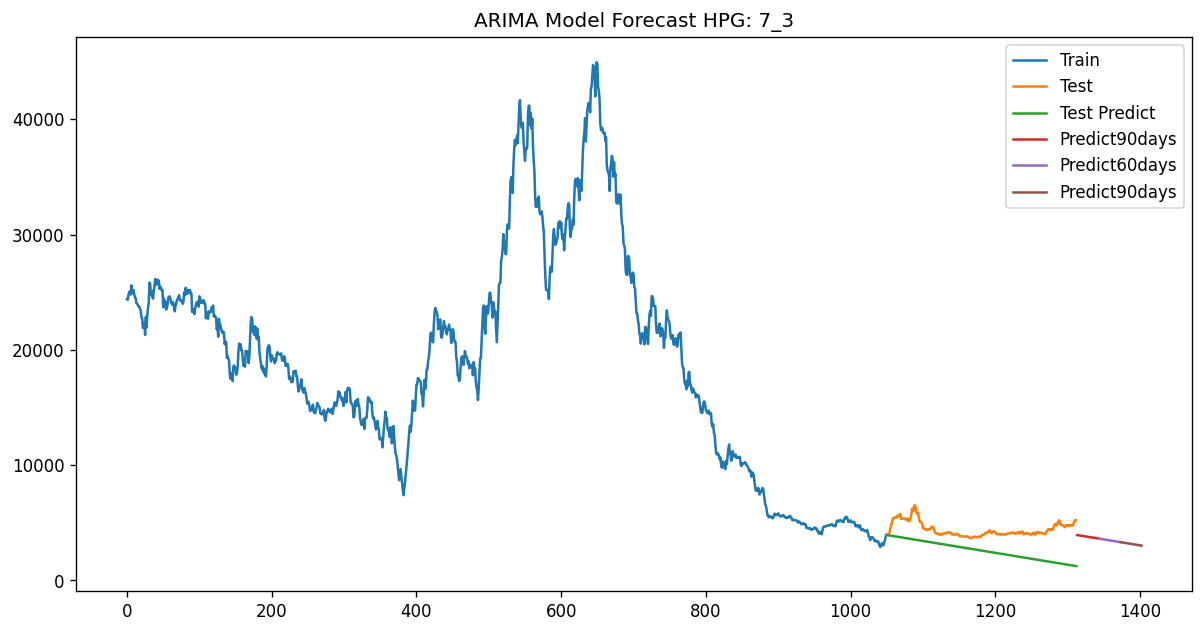

In [17]:
# Tạo DataFrame cho dự đoán test
test_predict_df = pd.DataFrame(y_pred, columns=['Price'])
test_predict_index = range(len(train_data), len(train_data)+ len(y_pred)) 
test_predict_df.index = test_predict_index

# Tạo DataFrame cho dữ liệu huấn luyện và kiểm tra
train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]

next_90_days_index = np.arange(len(df), len(df) + 90)
next_90_days_df = pd.DataFrame(y_next_90_days, index=next_90_days_index, columns=['Price'])

# Vẽ đồ thị
plt.figure(figsize=(12, 6))

# Vẽ dữ liệu huấn luyện
plt.plot(train_data_df, label='Train')

# Vẽ dữ liệu kiểm tra
plt.plot(test_data_df, label='Actual Test')

# Vẽ dự báo test predict
plt.plot(test_predict_df.index, test_predict_df['Price'], label='Test Predict')

# Vẽ dự báo 30 ngày đầu 

plt.plot(next_90_days_df.index[:30], next_90_days_df['Price'][:30], label='Next 30 days')
plt.plot(next_90_days_df.index[30:60], next_90_days_df['Price'][30:60], label='Next 60 days')
plt.plot(next_90_days_df.index[60:], next_90_days_df['Price'][60:], label='Next 90 days')

# Thêm chú thích và hiển thị đồ thị
plt.title('ARIMA Model Forecast HPG: 7_3')
plt.legend(['Train', 'Test', 'Test Predict', 'Predict90days', 'Predict60days', 'Predict90days'])
plt.show()

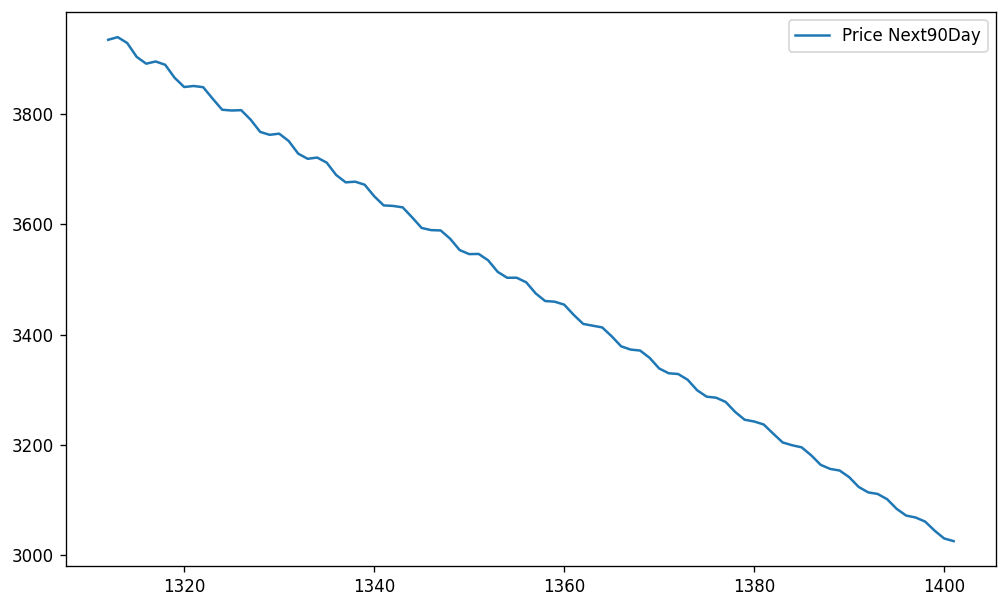

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(last_data,y_next_90_days)
plt.legend(['Price Next90Day'])
plt.show()